In [19]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import warnings
import spacy

from textblob import TextBlob
from IPython.display import display, HTML, Markdown

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import string
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from collections import Counter
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# statistics
from scipy.stats import ttest_rel, ttest_ind
import statsmodels.formula.api as smf

warnings.filterwarnings('ignore') # remove the warnings

In [3]:
def load_txt_file(website, Nb_files):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files 
        # Need to be outside of the repo folder and might need to change the path according to one's unique folders configuration
        directory = './../../dataset_BeerReviews/BeerAdvocate/ratings_split_BA/'
    else:
        directory = './../../dataset_BeerReviews/RateBeer/ratings_split_RB/'
        
    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(Nb_files, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns depending on the website
    if website == 'BeerAdvocate':
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text',
            'review'] # additional column compared to RB
    else:
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text']
    return final_df

def sample_data(df, ratio):
    # sample the data to make it even smaller
    return df.sample(frac = ratio, random_state=42)

In [4]:
# Load data : for faster processing, we will only load 1 file out of the whole dataset
ratings_BA = load_txt_file('BeerAdvocate', 2)
ratings_RB = load_txt_file('RateBeer', 2)

In [5]:
# Sample data to make it even smaller AND RANDOMIZED (not randomized in the initial txt splitting process)
ratings_BA = sample_data(df = ratings_BA, ratio = 0.25)
ratings_RB = sample_data(df = ratings_RB, ratio = 0.25)

In [6]:
# BeerAdvocate
beers_BA = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./../ada-2023-project-laremontada61/dataset_BeerReviews/matched_beer_data/users.csv", header=1)

In [8]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,object,object
brewery_name,object,object
brewery_id,object,object
style,object,object
abv,object,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,object


In [9]:
def convert_type(df, col):
    df[col] = df[col].astype('float64')
    return df

# columns including the numerical features for both websites
# user_id is numerical in RB but categorical in BA so we don't include it
numerical_cols = ['beer_id', 'brewery_id', 'abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in numerical_cols : 
    ratings_BA = convert_type(ratings_BA, col)
    ratings_RB = convert_type(ratings_RB, col)

In [10]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,float64,float64
brewery_name,object,object
brewery_id,float64,float64
style,object,object
abv,float64,float64
date,object,object
user_name,object,object
user_id,object,object
appearance,float64,float64


In [11]:
def add_time_features(df):
    """
    Adds a 'month' and a 'year' features to the DataFrame based on the 'date' column.
    
    Parameters
    ----------
    df : DataFrame
        Contains data including a 'date' column.

    Returns
    -------
    df_m : DataFrame
        Contains the original data with an additional 'month' and 'year' features.
    """
    # Create a copy of the DataFrame
    df_time = df.copy()
    # Conversion of date feature from timestamp to text date
    pd.to_numeric(df_time['date'], errors='coerce', downcast='integer')
    # Convert 'date' to datetime and extract the date
    df_time.date = df.date.apply(lambda d: pd.to_datetime(d, unit='s'))
    df_time['date'] = df_time['date'].dt.date

    # Extract the month from the 'date' column and add it as a new feature 'month'
    df_time['month'] = pd.to_datetime(df_time['date']).dt.month
    # Extract the year from the 'date' column and add it as a new feature 'year'
    df_time['year'] = pd.to_datetime(df_time['date']).dt.year

    return df_time

def standardize_annually_ratings(df):
    """
    Standardizes the ratings annually and per website.
    
    Parameters
    ----------
    df : DataFrame
        Containing all data

    Returns
    -------
    df : DataFrame
        Containing all data with standardized ratings with additional column 'standardized_rating'.
                
    """
    df_copy = df.copy()
    grouped = df_copy.groupby('year')['rating'].agg(['mean', 'std'])
    df_copy = pd.merge(df_copy, grouped, left_on='year', right_index=True)
    df_copy['std_rating'] = (df_copy['rating'] - df_copy['mean']) / df_copy['std']
    
    return df_copy, grouped

In [12]:
# add time feature to standardize ratings by year and by website
ratings_BA_with_time = add_time_features(ratings_BA)
ratings_RB_with_time = add_time_features(ratings_RB)

# apply standardization
ratings_BA_standardized, mean_std_BA = standardize_annually_ratings(ratings_BA_with_time)
ratings_RB_standardized, mean_std_RB = standardize_annually_ratings(ratings_RB_with_time)

In [13]:
ratings_matched_copy = ratings_matched.copy(deep=True)
ratings_matched_copy['beer_id.1'] = ratings_matched_copy['beer_id']
ratings_matched_copy['brewery_id.1'] = ratings_matched_copy['brewery_id']
ratings_matched_copy['beer_name.1'] = ratings_matched_copy['beer_name']
ratings_matched_copy['brewery_name.1'] = ratings_matched_copy['brewery_name']

# Retrieve the columns of interest for BeerAdvocate
ratings_matched_BA = ratings_matched_copy.iloc[:, :17]
ratings_matched_BA = ratings_matched_BA.drop(['review'], axis=1) # drop the column that is not common to both websites

#Retrieve the columns of interest for RateBeer
ratings_matched_RB = ratings_matched_copy.iloc[:, 17:]
ratings_matched_RB['overall.1'] = ratings_matched_RB['overall.1']*5/20
ratings_matched_RB['aroma.1'] = ratings_matched_RB['aroma.1']*5/10
ratings_matched_RB['taste.1'] = ratings_matched_RB['taste.1']*5/10
ratings_matched_RB.columns = ratings_matched_BA.columns

# add time features to standardize by year
ratings_matched_BA_with_time = add_time_features(ratings_matched_BA)
ratings_matched_RB_with_time = add_time_features(ratings_matched_RB)

# standardize ratings of matched data to have mean 0 and std 1
ratings_matched_BA_standardized, mean_std_BA_matched = standardize_annually_ratings(ratings_matched_BA_with_time) # adds column 'std_rating'
ratings_matched_RB_standardized, mean_std_RB_matched = standardize_annually_ratings(ratings_matched_RB_with_time) # adds column 'std_rating'

Length of ratings matched: 21964
Length of ratings BA: 222169
Length of ratings RB: 211679
Length of combined dataset: 477774


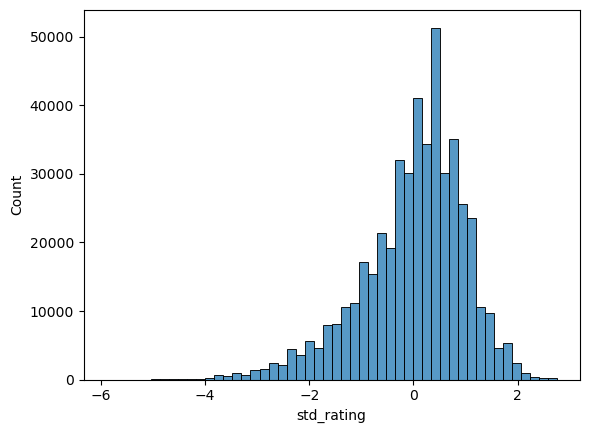

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,taste,overall,rating,text,review,month,year,mean,std,std_rating
277730,Weihenstephaner Hefeweissbier Dunkel,808.0,Bayerische Staatsbrauerei Weihenstephan,252.0,Dunkelweizen,5.3,2013-11-10,dcmchew,dcmchew.760280,4.5,...,4.25,4.25,4.27,nan,False,11.0,2013.0,3.669952,0.698321,0.859273
673652,Corona Light,233.0,Grupo Modelo S.A. de C.V.,75.0,Light Lager,4.1,2013-12-27,JayJ14,jayj14.772458,NaN,...,NaN,NaN,3.00,nan,False,12.0,2013.0,3.669952,0.698321,-0.959375


In [14]:
# concatenate matched data from both websites
ratings_matched_BA_RB = pd.concat([ratings_matched_BA_standardized, ratings_matched_RB_standardized], axis=0)
ratings_matched_BA_RB.sort_values(by=['beer_id', 'user_id'], inplace=True)

# concatenate matched data with ratings_BA and ratings_RB
all_data= pd.concat([ratings_BA_standardized, 
                    ratings_RB_standardized,
                    ratings_matched_BA_RB], axis=0)

# test
print(f"Length of ratings matched: {len(ratings_matched)}")
print(f"Length of ratings BA: {len(ratings_BA)}")
print(f"Length of ratings RB: {len(ratings_RB)}")
print(f"Length of combined dataset: {len(all_data)}")

# check
sns.histplot(data=all_data['std_rating'], bins=50)
plt.show()

all_data.head(2)

In [15]:
nltk.download('words')
nltk.download('stopwords') # Download NLTK stopwords
nltk.download('wordnet')   # Lemmatization
nltk.download('words')
english_words=set(words.words())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [16]:

def remove_no_sentences(df):
    df = df.dropna(subset=['text'])
    df = df[df['text'].str.strip().astype(bool)]  # Check for non-empty strings
    df = df[df['text'] != 'nan']
    return df
def keep_only_english(sentence):
    return " ".join(w for w in nltk.wordpunct_tokenize(sentence) if w.lower() in english_words or not w.isalpha())



In [17]:
all_data = remove_no_sentences(all_data)
all_data['text'] = all_data['text'].apply(lambda x: keep_only_english(x))

In [20]:
analyzer = SentimentIntensityAnalyzer()

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return analyzer.polarity_scores(text)

In [21]:
all_data['polarity_text'] = all_data['text'].apply(lambda x: getPolarity(x))
all_data['polarity_rating'] = all_data['text'].apply(lambda x: getPolarity(x)['compound'])
all_data['subjectivity'] = all_data['text'].apply(lambda x: getSubjectivity(x))
all_data.head(5)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,text,review,month,year,mean,std,std_rating,polarity_text,polarity_rating,subjectivity
60909,Open Baladin,50591.0,Birrificio Le Baladin,1675.0,Belgian Pale Ale,7.5,2013-03-20,stcules,stcules.473,3.00,...,"Light orange color , slightly veiled , good ca...",True,3.0,2013.0,3.669952,0.698321,-1.460578,"{'neg': 0.173, 'neu': 0.738, 'pos': 0.089, 'co...",-0.8182,0.502193
834607,Deviator Doppelbock,75943.0,Cameron's Brewing Co.,3912.0,Doppelbock,7.1,2013-12-30,seand,seand.289492,3.00,...,A : a dark translucent brown with a small amou...,True,12.0,2013.0,3.669952,0.698321,-0.286332,"{'neg': 0.023, 'neu': 0.843, 'pos': 0.133, 'co...",0.8873,0.604167
344419,Mornington Peninsula Imperial IPA,68411.0,Mornington Peninsula Brewery,24486.0,American Double / Imperial IPA,8.5,2013-06-15,soju6,soju6.436826,4.00,...,A : a mahogany color with a tan head that to s...,True,6.0,2013.0,3.669952,0.698321,0.171910,"{'neg': 0.023, 'neu': 0.773, 'pos': 0.204, 'co...",0.9570,0.523704
123040,USAlive! (Alive),48238.0,Mikkeller ApS,13307.0,Belgian Strong Pale Ale,8.0,2013-09-02,kylehay2004,kylehay2004.571365,4.00,...,A : single finger thick off white head with ni...,True,9.0,2013.0,3.669952,0.698321,-0.801855,"{'neg': 0.051, 'neu': 0.879, 'pos': 0.07, 'com...",0.3947,0.471988
310588,Spaten Dunkel,47748.0,Spaten-Franziskaner-Bräu,142.0,Munich Dunkel Lager,5.5,2013-07-03,wac9,wac9.144224,3.75,...,what a wonderful beer its a great tasting beer...,True,7.0,2013.0,3.669952,0.698321,-0.572734,"{'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'comp...",0.9719,0.477778
